In [1]:
import sys
sys.path.append("../../")

In [2]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.test_functions.multi_objective import GMM, BraninCurrin, DTLZ3, Penicillin
from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cpu"),
}
SEED = 42
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# define problem
# problem = DTLZ3(dim=3, negate=True).to(**tkwargs)
# problem = BraninCurrin(negate=True).to(**tkwargs)
problem = GMM(negate=True).to(**tkwargs)
# problem.ref_point = torch.tensor([0., 0.], **tkwargs)

## Problem

The approximated pareto set and pareto front is shown in the following figure.

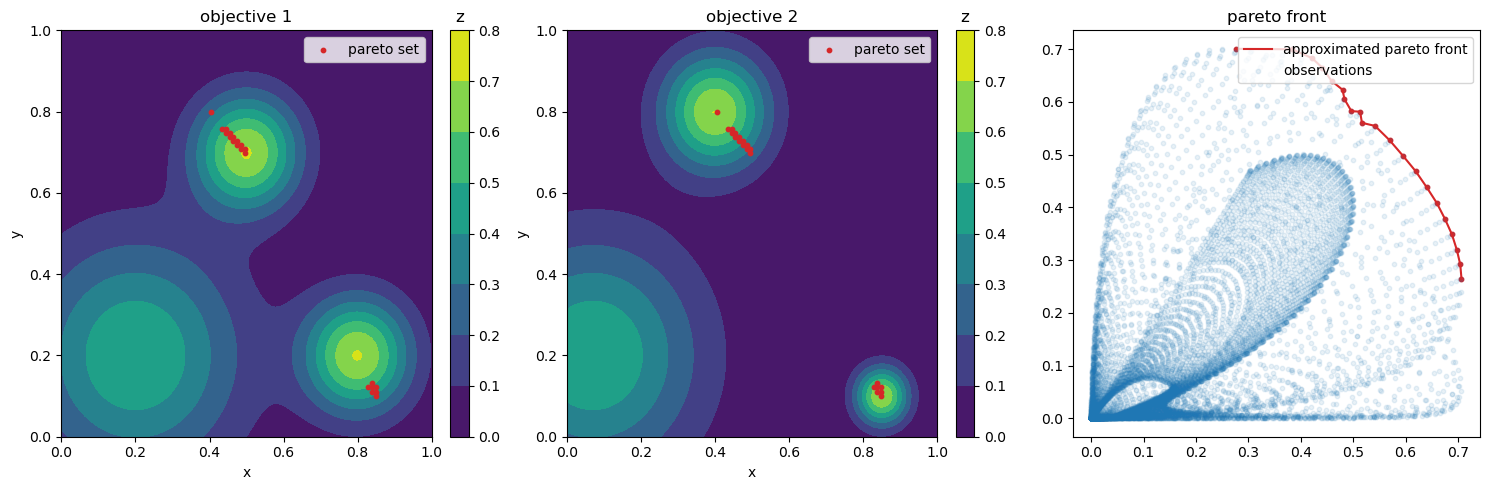

In [4]:
from plot_utils import plot_objective

plot_objective(problem, num_samples=100)

In [5]:
def generate_initial_data(problem, n=6):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj = problem(train_x)
    return train_x, train_obj

In [6]:
init_x, init_y = generate_initial_data(problem, n=6)

## Generate data

In [7]:
from optimizers.mbore.mbore_mdre_ei import MBORE_MDRE_EI
from optimizers.mbore.mbore_mdre_ei_unnorm import MBORE_MDRE_EI_UNNORM
from optimizers.mbore.mbore_mdre_ei_randm import MBORE_MDRE_EI_RANDM

In [8]:
def plot_input_space(xx, yy, x_obs, preds, fig, ax, title=None):
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # plot functions
    countourset = ax.contourf(
        xx,
        yy,
        preds.reshape(xx.shape),
    )
    ax.scatter(*x_obs.t(), alpha=0.3, s=10, color='tab:red')

    cax.grid(False)  # just to remove the warning
    clb = fig.colorbar(countourset, cax=cax)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title(title)
    clb.ax.set_title('z')


def plot_pareto_space(y_obs, pareto, l, u_nbd, ax, title='pareto'):
    ax.scatter(*y_obs[~pareto].t(), s=10, alpha=0.3)
    ax.scatter(*l.t(), s=10, color='tab:red', label="pareto")
    ax.plot(*l.t(), color='tab:red')
    # ax.scatter(*u_nbd.t(), s=10, label="non dominated", color='tab:purple')
    ax.scatter(*problem.ref_point.t(), s=10, color='k', label="ref point")

    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_title(title)
    ax.legend()


def plot_pareto_box(tau, boxes, ax):
    ax.scatter(*tau.t(), label=r"$\mathbf{\tau}$")
    pc = PatchCollection(boxes, cmap='tab10', alpha=.3)
    pc.set_array(torch.arange(0, len(boxes)))
    ax.add_collection(pc)
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    ax.axvspan(x_lim[0], tau[0], alpha=0.1, color='tab:gray')
    ax.axhspan(y_lim[0], tau[1], alpha=0.1, color='tab:gray')
    ax.set_xlim(*x_lim)
    ax.set_ylim(*y_lim)

In [9]:
x_obs = init_x
y_obs = init_y

num_obj = problem.num_objectives
# only plot the first two dimensions
xx, yy = np.meshgrid(
    np.linspace(
        *problem.bounds.t()[0], 100
    ),
    np.linspace(
        *problem.bounds.t()[1], 100
    ),
)
x_cands = np.vstack((xx.flatten(), yy.flatten())).T
x_cands = torch.from_numpy(x_cands).to(**tkwargs)
y_cands = problem(x_cands).reshape(100, 100, num_obj)
xx_obj, yy_obj = y_cands[:, :, 0], y_cands[:, :, 1]

2024-07-03 13:25:56,017 | optimizers.mbore.mbore_mdre_ei_randm


Iteration 0


100%|██████████| 500/500 [00:01<00:00, 302.30it/s]
2024-07-03 13:26:00,308 | Model fitting takes 4.27s
2024-07-03 13:26:00,322 | Optimizing the acquisition function takes 0.01s


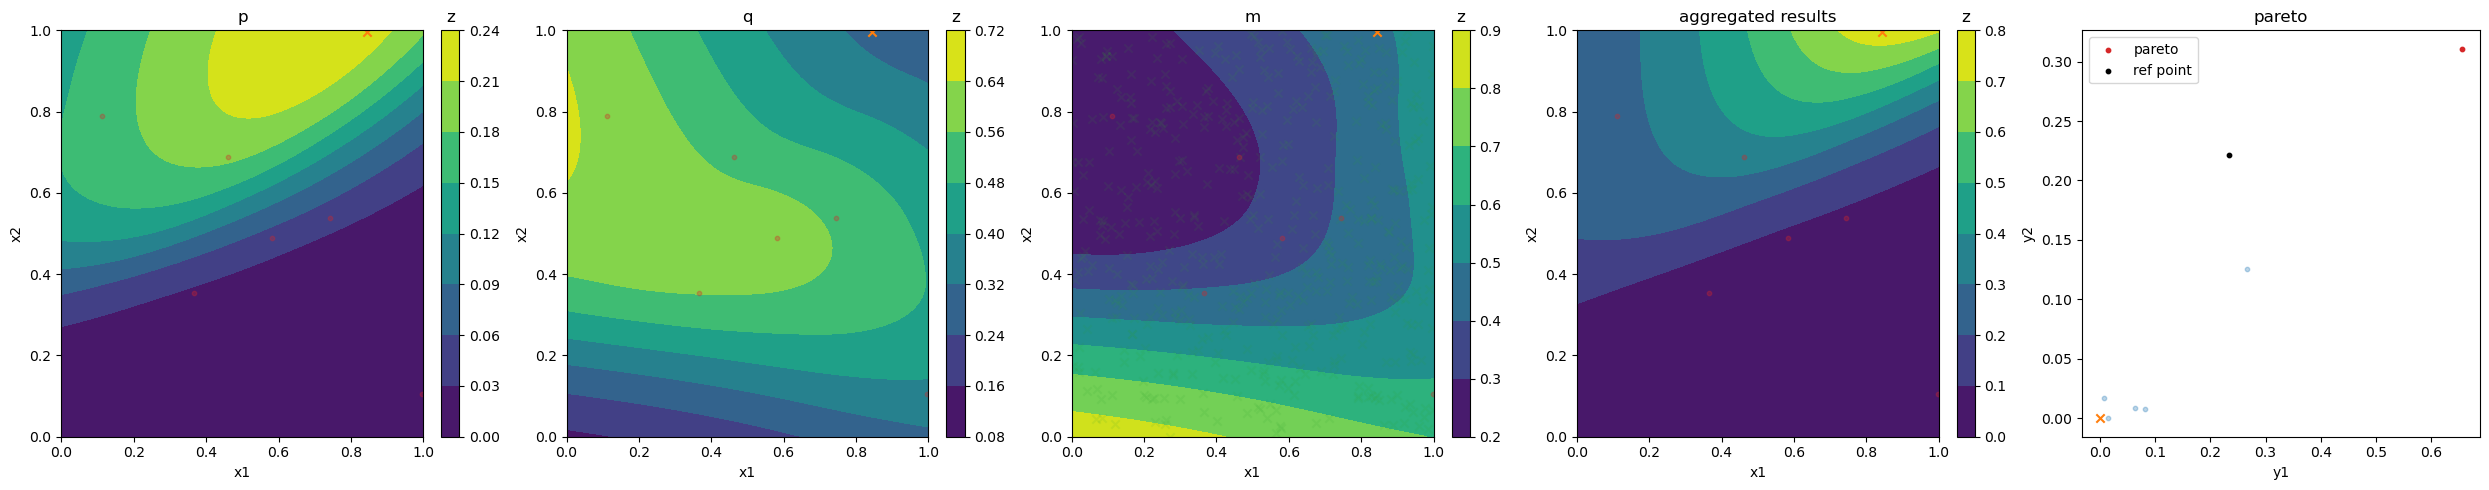

Iteration 1


100%|██████████| 500/500 [00:01<00:00, 344.64it/s]
2024-07-03 13:26:04,981 | Model fitting takes 3.54s
2024-07-03 13:26:04,990 | Optimizing the acquisition function takes 0.00s


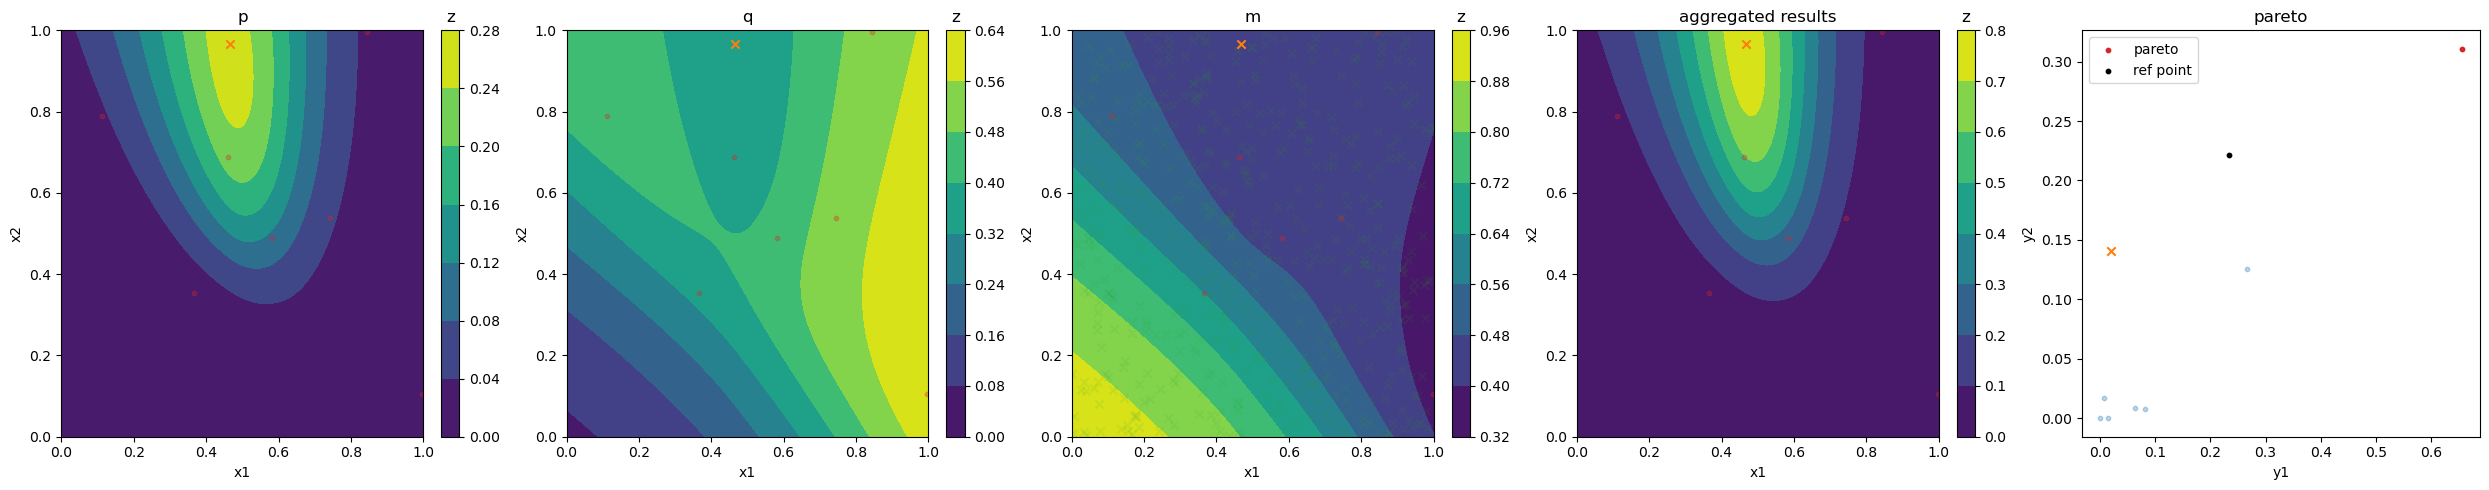

Iteration 2


100%|██████████| 500/500 [00:01<00:00, 269.42it/s]
2024-07-03 13:26:10,396 | Model fitting takes 4.22s
2024-07-03 13:26:10,399 | Optimizing the acquisition function takes 0.00s


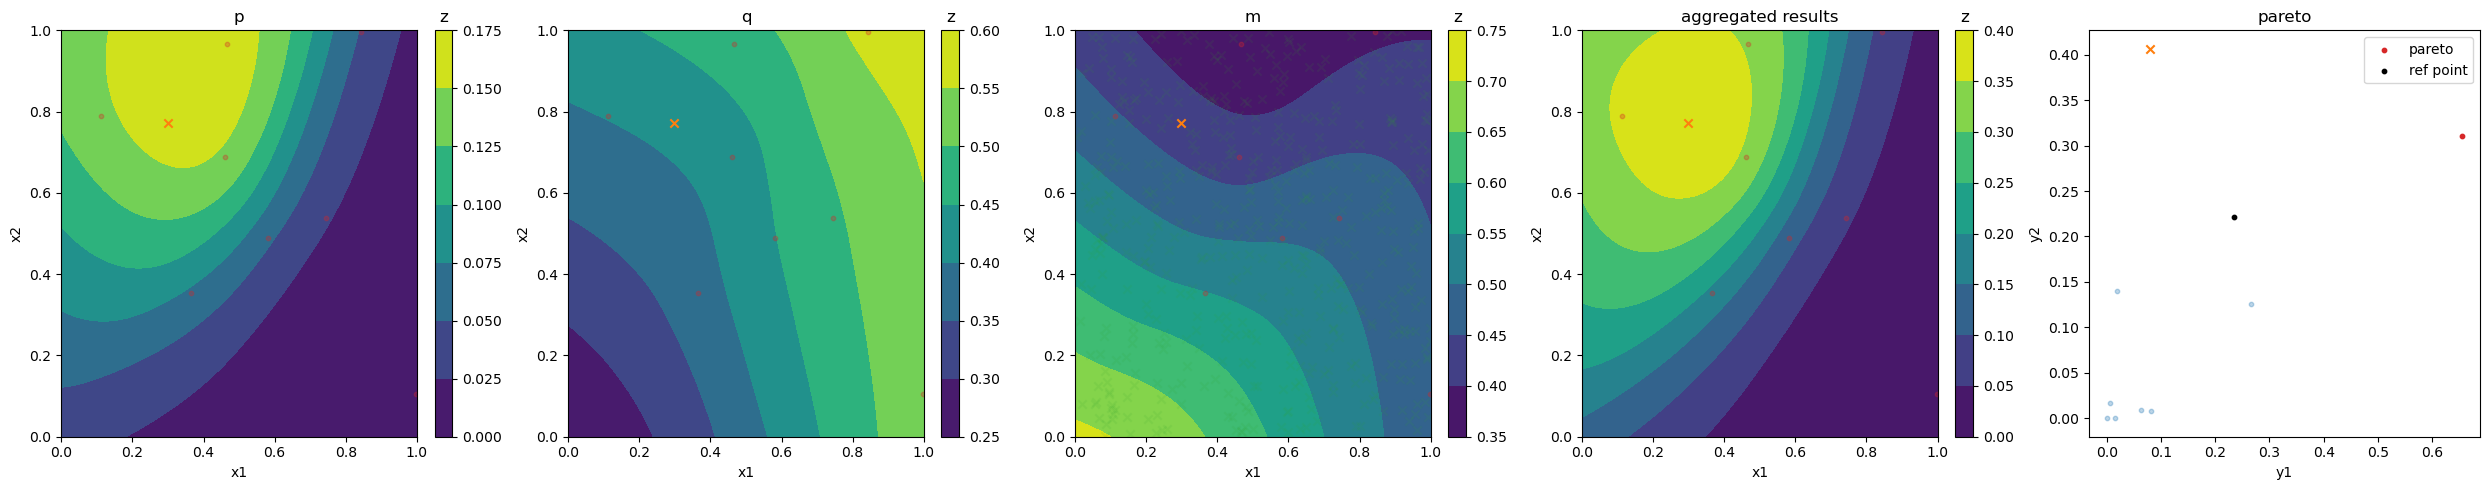

Iteration 3


100%|██████████| 500/500 [00:01<00:00, 285.29it/s]
2024-07-03 13:26:15,466 | Model fitting takes 3.95s
2024-07-03 13:26:15,472 | Optimizing the acquisition function takes 0.00s


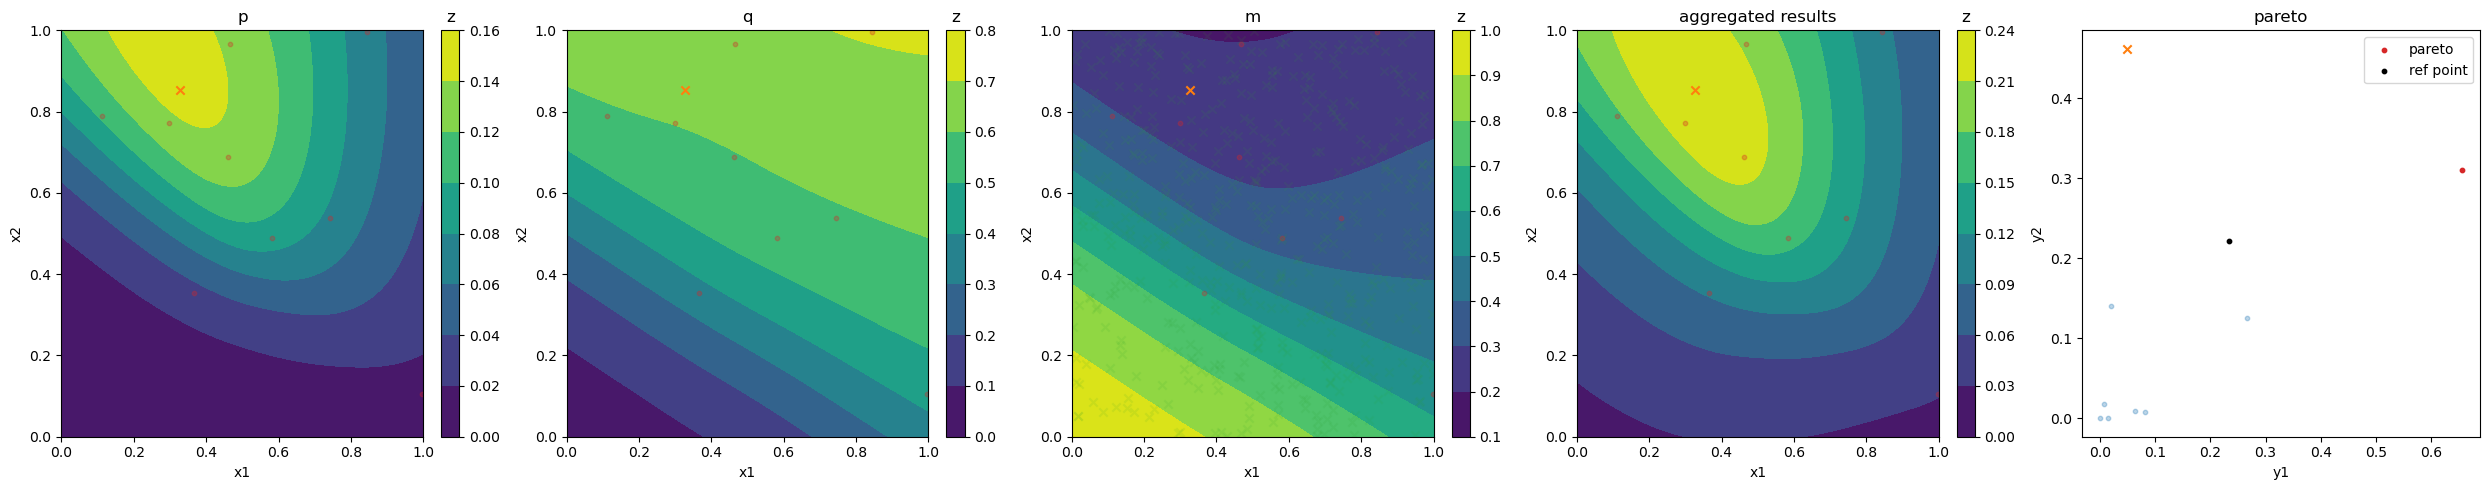

Iteration 4


100%|██████████| 500/500 [00:01<00:00, 281.90it/s]
2024-07-03 13:26:20,724 | Model fitting takes 4.03s
2024-07-03 13:26:20,729 | Optimizing the acquisition function takes 0.00s


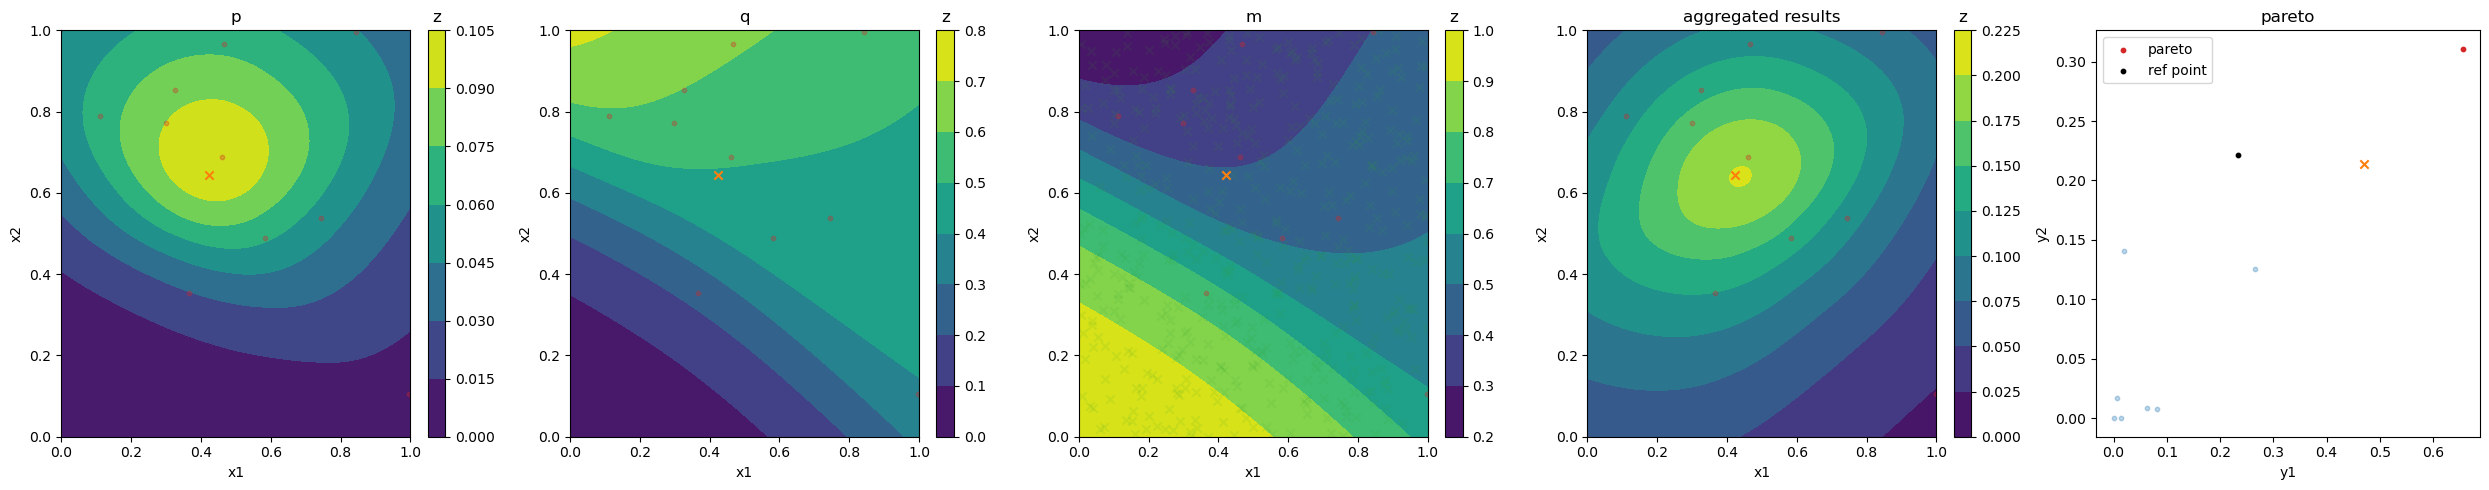

Iteration 5


100%|██████████| 500/500 [00:01<00:00, 303.73it/s]
2024-07-03 13:26:25,447 | Model fitting takes 3.70s
2024-07-03 13:26:25,450 | Optimizing the acquisition function takes 0.00s


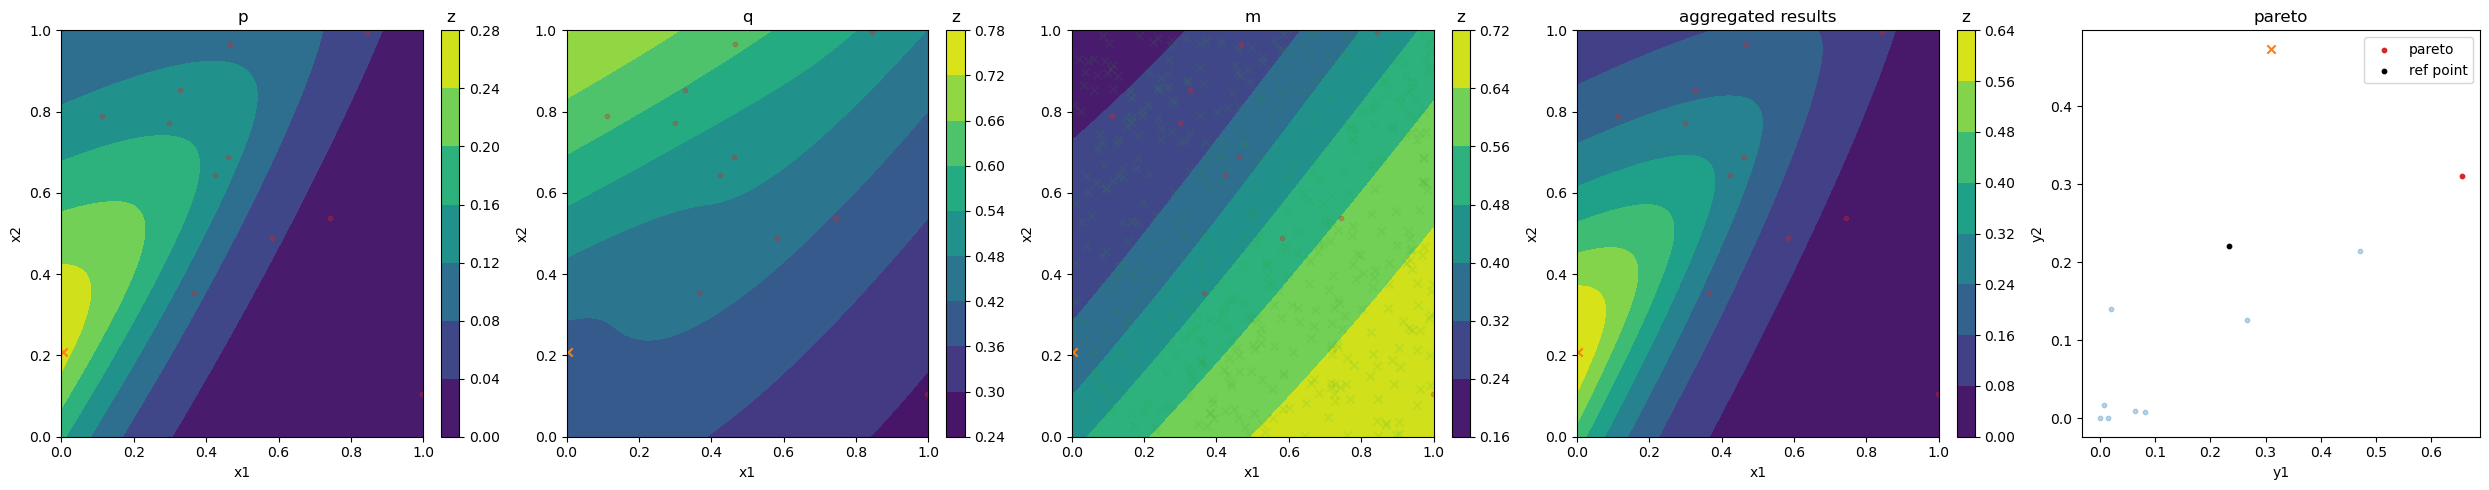

Iteration 6


100%|██████████| 500/500 [00:01<00:00, 262.96it/s]
2024-07-03 13:26:31,398 | Model fitting takes 4.81s
2024-07-03 13:26:31,414 | Optimizing the acquisition function takes 0.01s


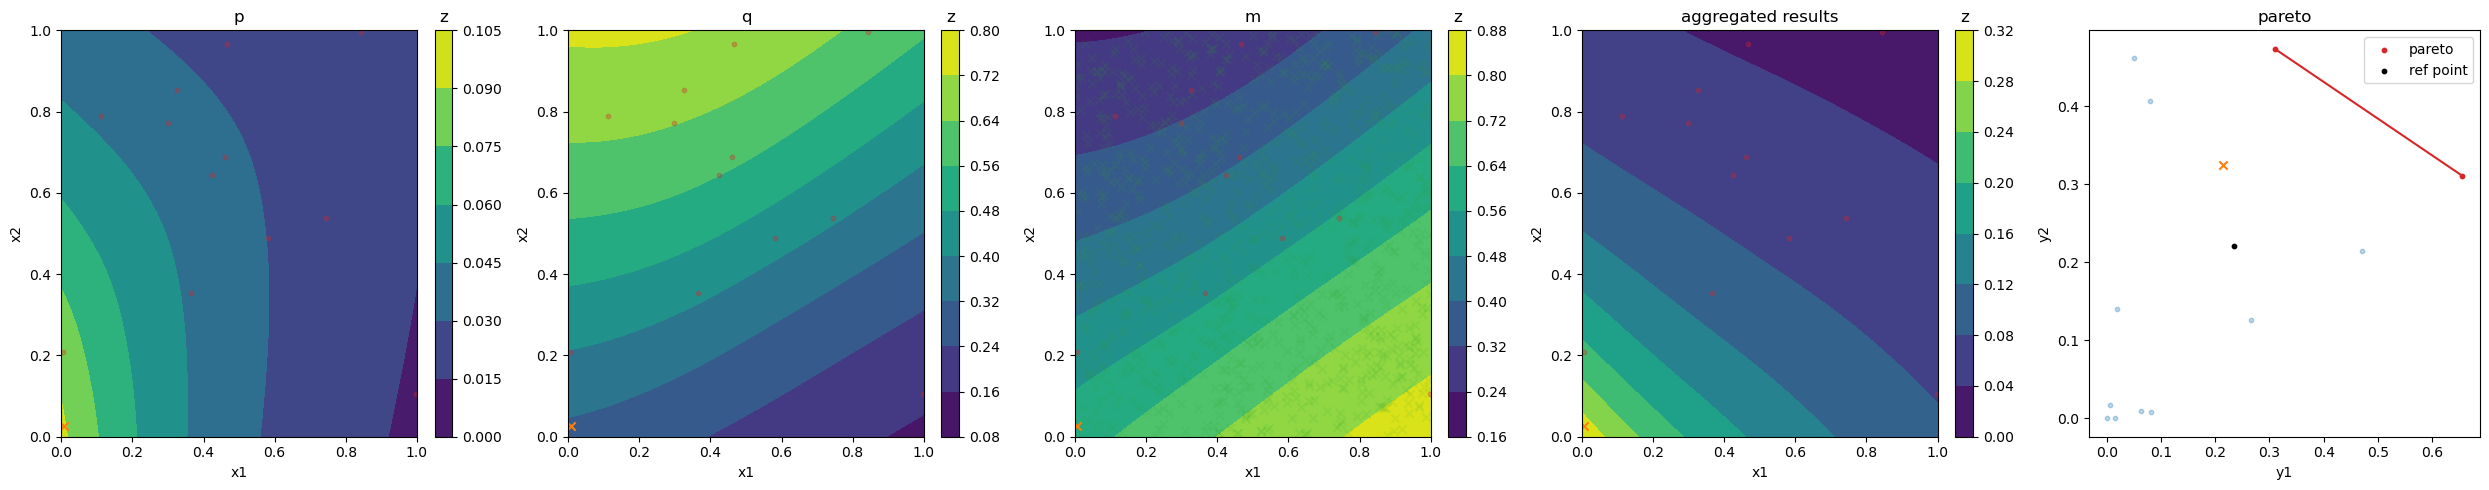

Iteration 7


100%|██████████| 500/500 [00:01<00:00, 319.85it/s]
2024-07-03 13:26:36,587 | Model fitting takes 3.95s
2024-07-03 13:26:36,592 | Optimizing the acquisition function takes 0.00s


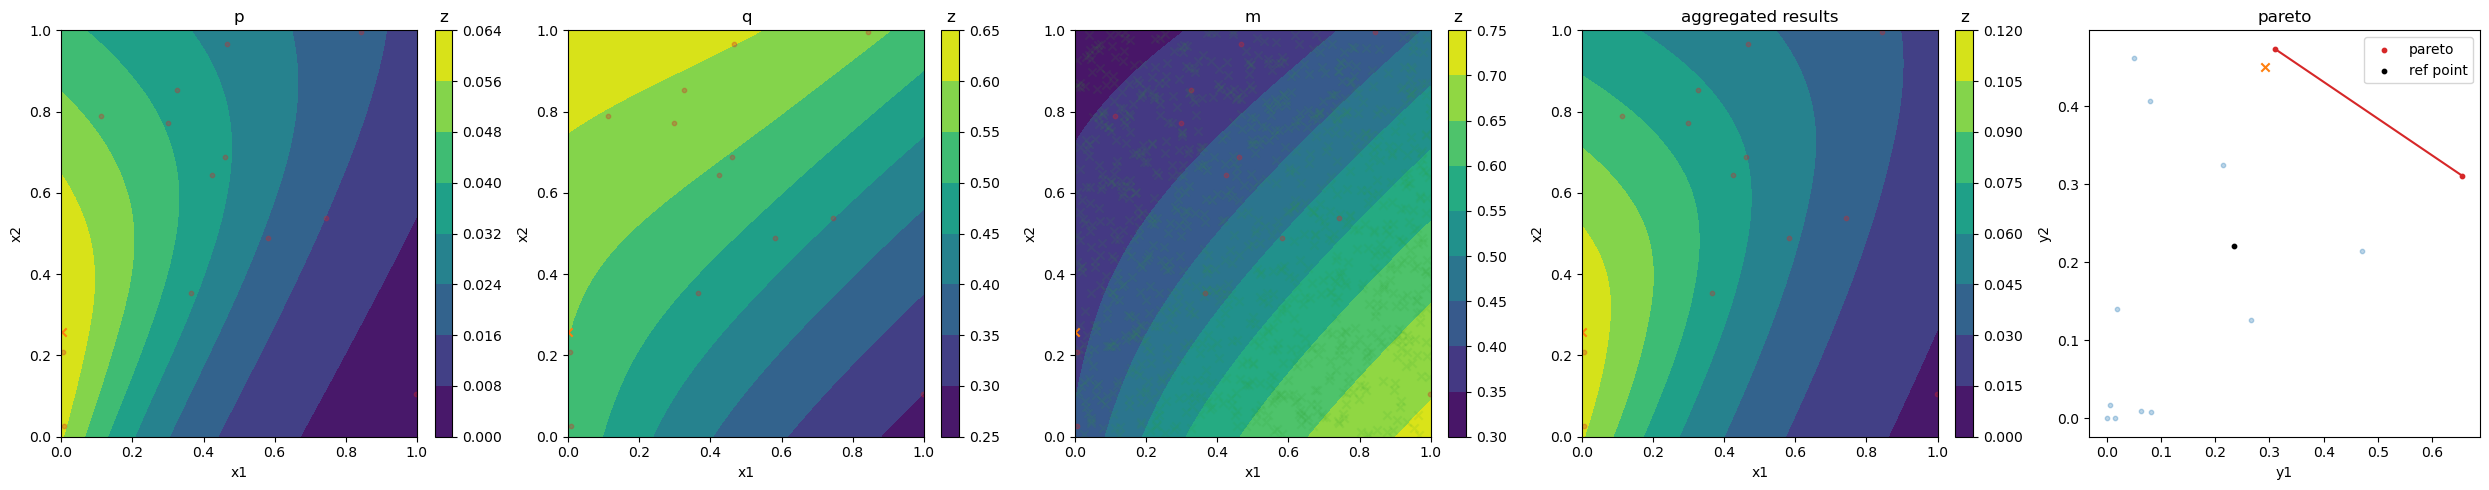

Iteration 8


100%|██████████| 500/500 [00:03<00:00, 166.17it/s]
2024-07-03 13:26:43,755 | Model fitting takes 5.97s
2024-07-03 13:26:43,759 | Optimizing the acquisition function takes 0.00s


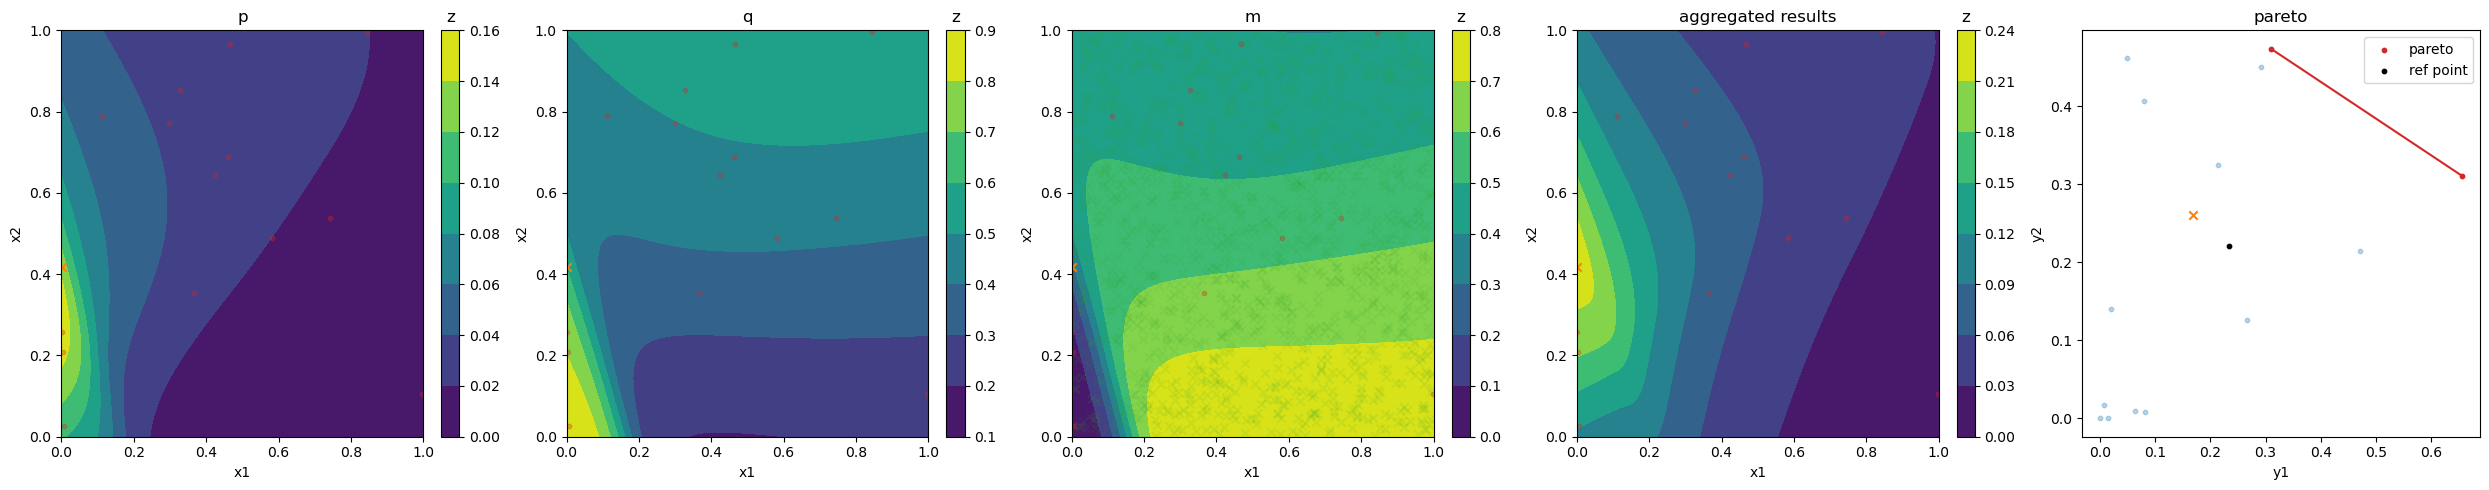

Iteration 9


100%|██████████| 500/500 [00:02<00:00, 213.51it/s]
2024-07-03 13:26:50,022 | Model fitting takes 5.02s
2024-07-03 13:26:50,026 | Optimizing the acquisition function takes 0.00s


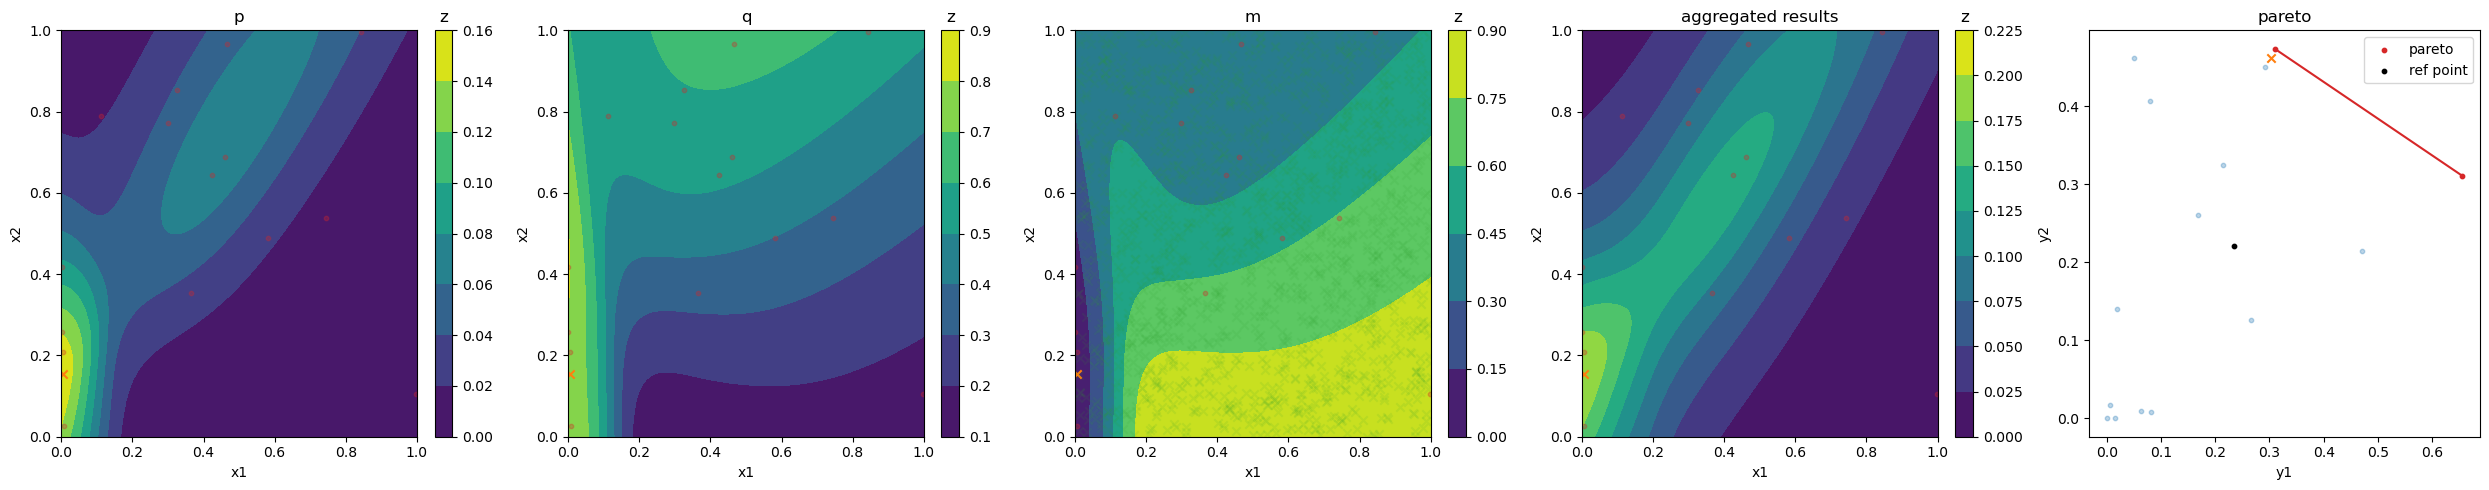

Iteration 10


100%|██████████| 500/500 [00:02<00:00, 205.48it/s]
2024-07-03 13:26:56,650 | Model fitting takes 5.36s
2024-07-03 13:26:56,655 | Optimizing the acquisition function takes 0.00s


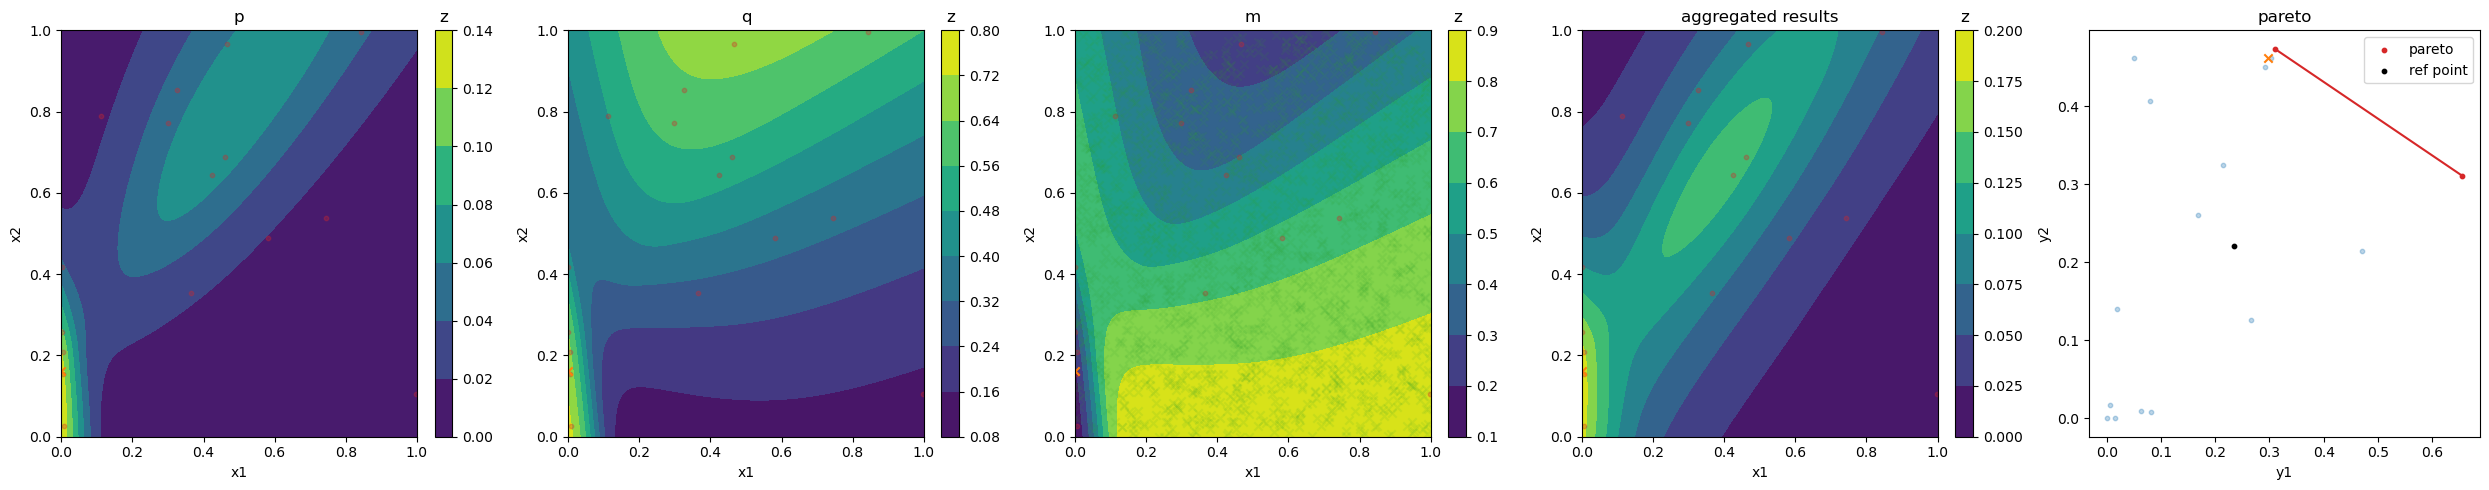

Iteration 11


100%|██████████| 500/500 [00:02<00:00, 208.80it/s]
2024-07-03 13:27:03,117 | Model fitting takes 5.12s
2024-07-03 13:27:03,122 | Optimizing the acquisition function takes 0.00s


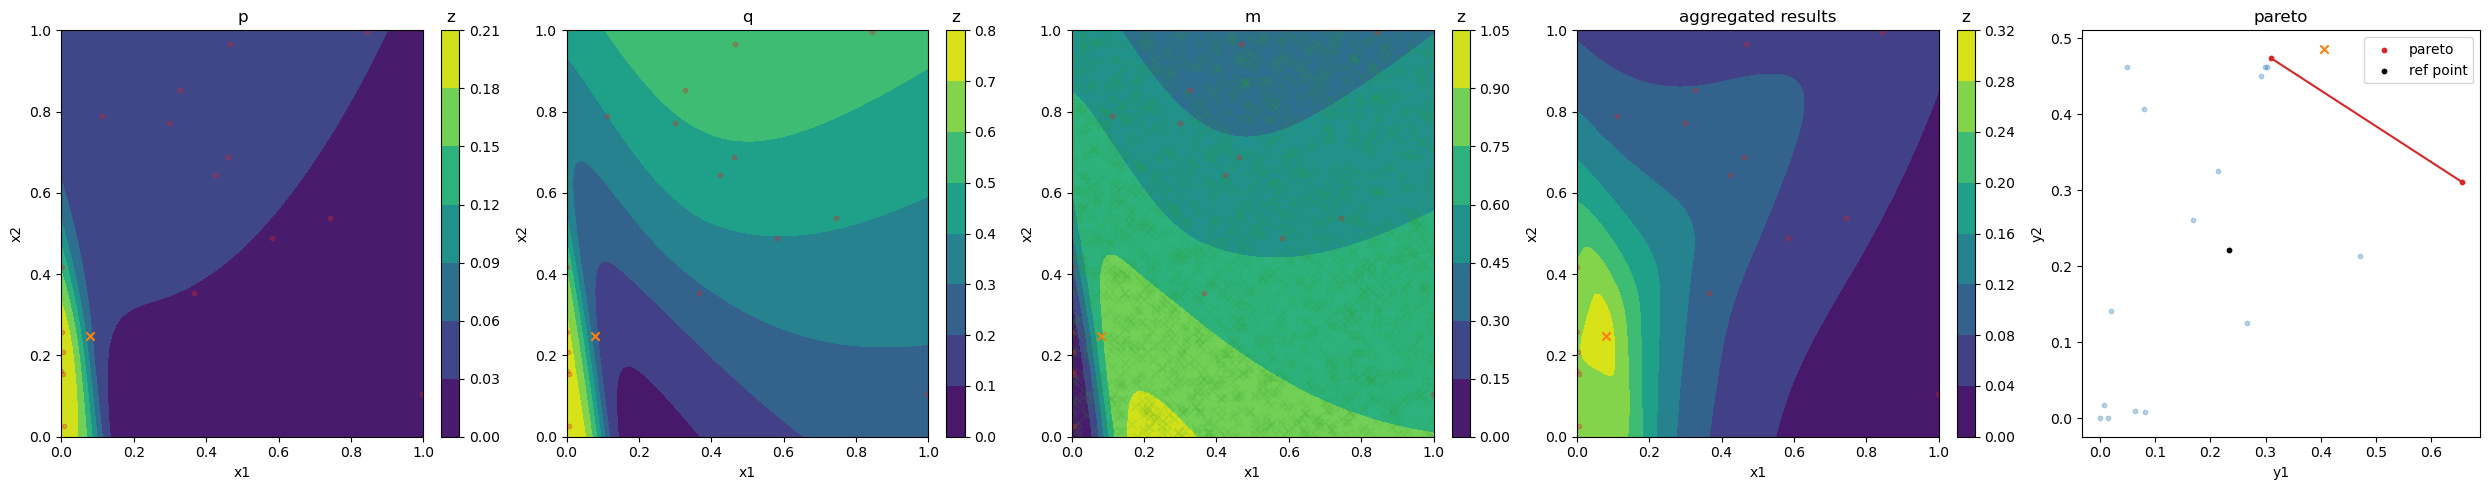

Iteration 12


100%|██████████| 500/500 [00:02<00:00, 173.64it/s]
2024-07-03 13:27:10,557 | Model fitting takes 5.74s
2024-07-03 13:27:10,560 | Optimizing the acquisition function takes 0.00s


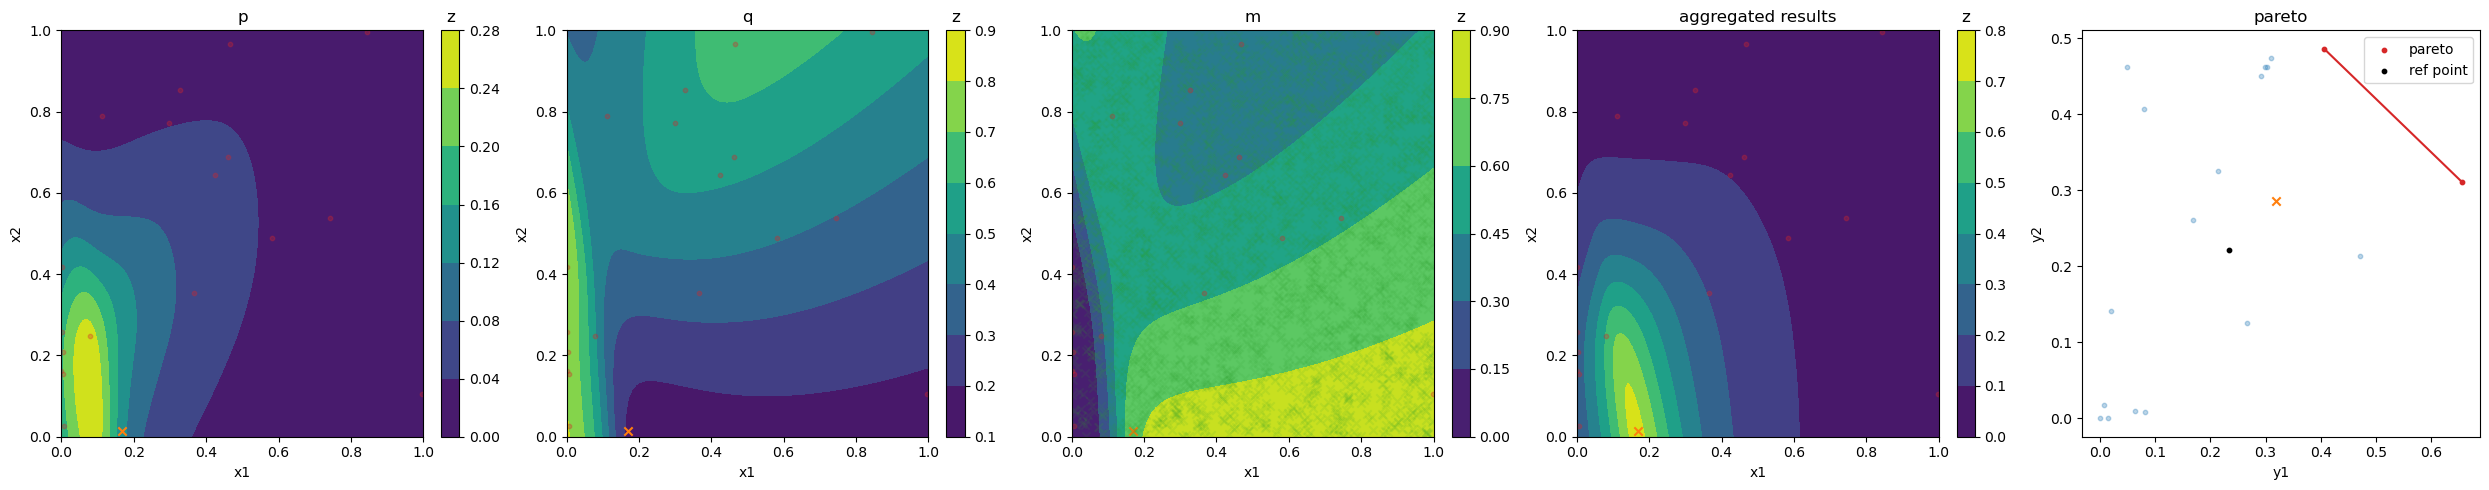

Iteration 13


100%|██████████| 500/500 [00:03<00:00, 164.46it/s]
2024-07-03 13:27:17,542 | Model fitting takes 5.78s
2024-07-03 13:27:17,546 | Optimizing the acquisition function takes 0.00s


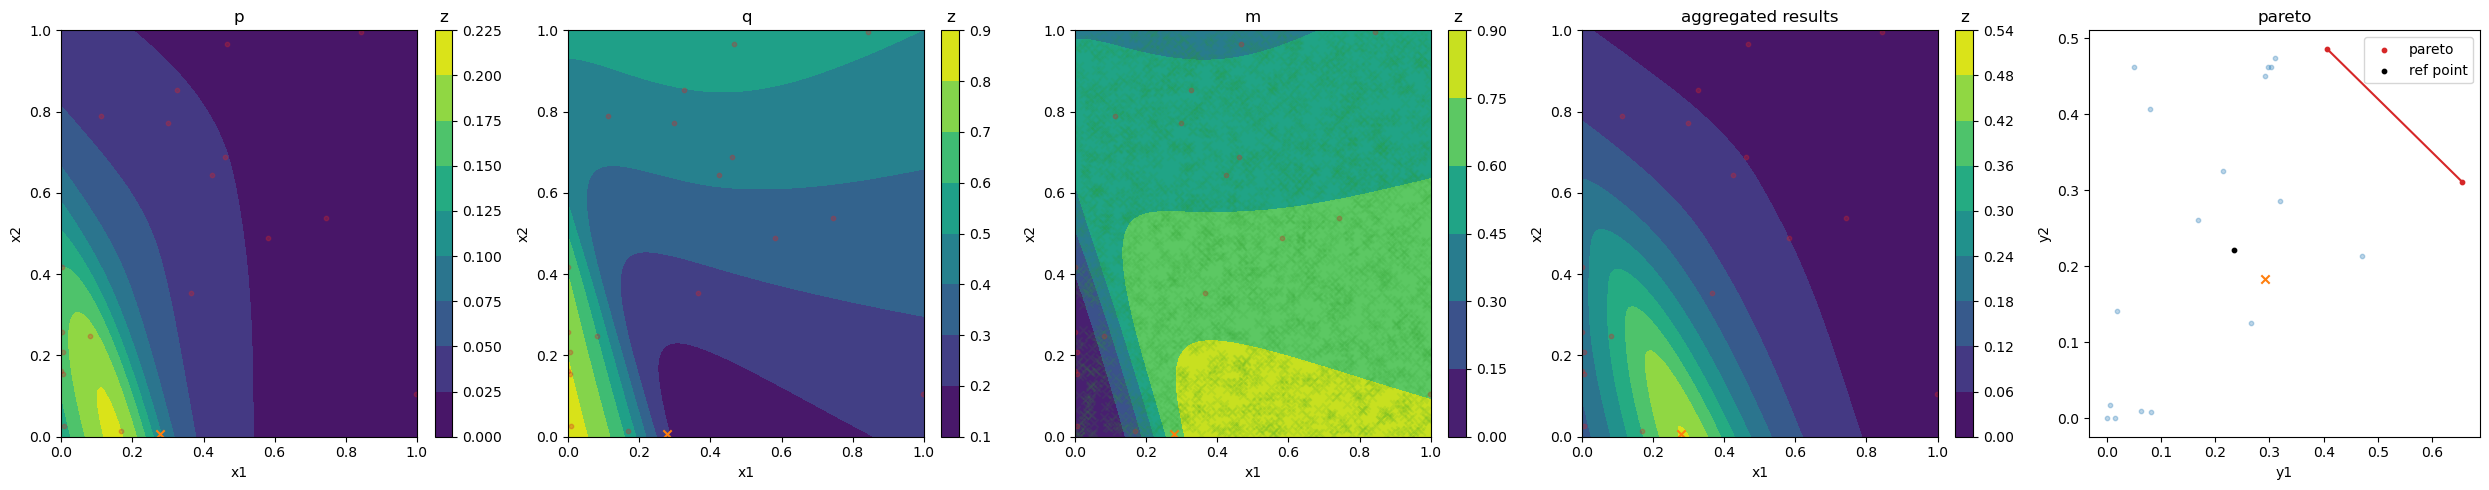

Iteration 14


100%|██████████| 500/500 [00:02<00:00, 212.70it/s]
2024-07-03 13:27:23,665 | Model fitting takes 5.03s
2024-07-03 13:27:23,674 | Optimizing the acquisition function takes 0.01s


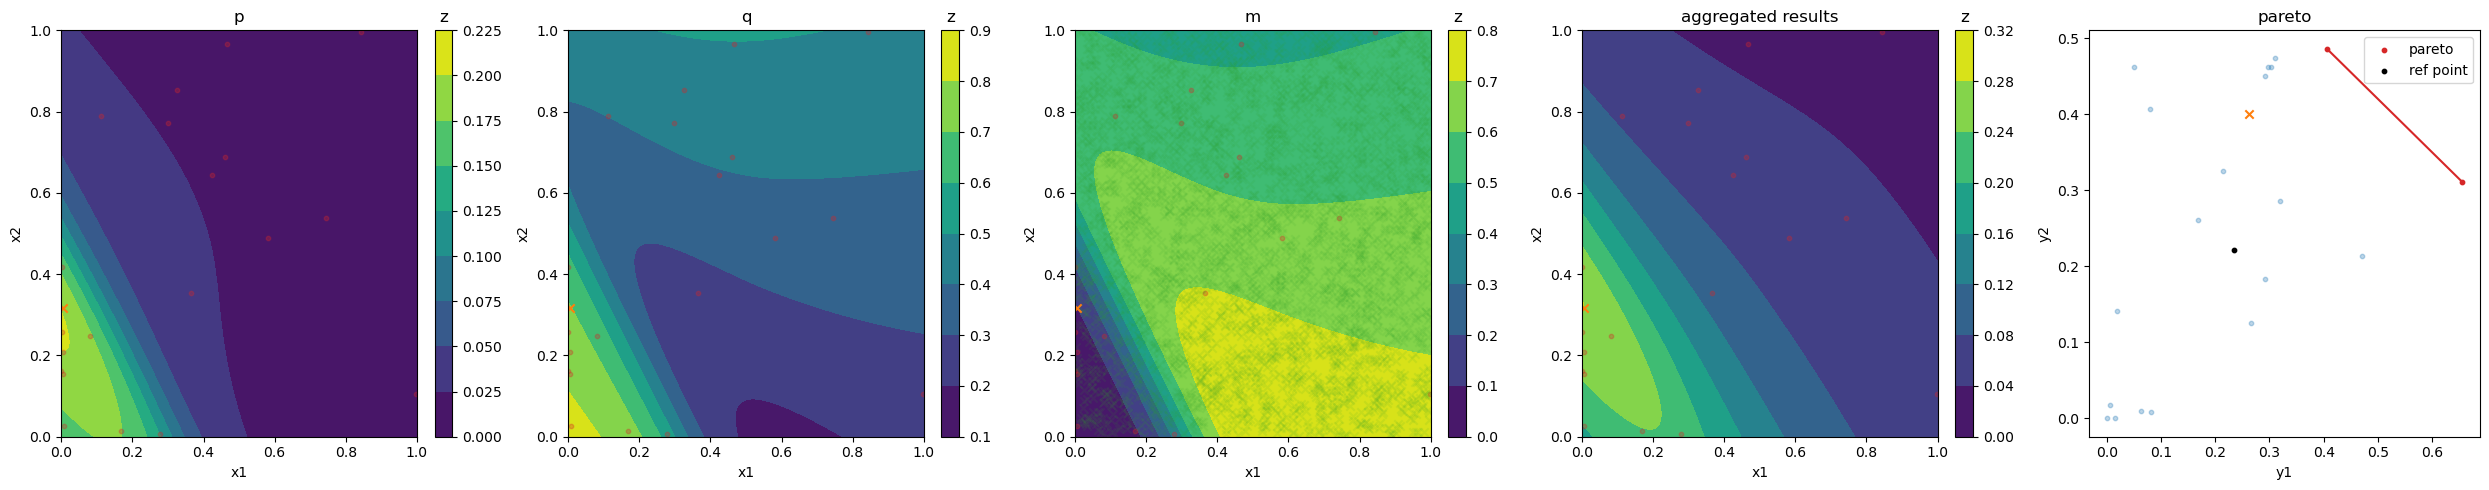

Iteration 15


 79%|███████▉  | 395/500 [00:03<00:00, 181.99it/s]

In [10]:
optimizer = MBORE_MDRE_EI_RANDM(
    problem=problem, 
)

for n in range(20):
    print(f"Iteration {n}")

    pareto = is_non_dominated(y_obs)
    bd = DominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    nbd = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=y_obs)
    u, l = bd.hypercell_bounds
    u_nbd, _ = nbd.hypercell_bounds

    boxes = [Rectangle(
        l_point.cpu(),
        *(u_point - l_point).cpu(),
    ) for l_point, u_point in zip(l, u)]


    new_x = optimizer.observe_and_suggest(x_obs, y_obs)
    new_y = problem(new_x)

    preds_p = torch.empty(0, **tkwargs)
    preds_q = torch.empty(0, **tkwargs)
    preds_m = torch.empty(0, **tkwargs)
    preds = torch.empty(0, **tkwargs)
    i = 0

    with torch.no_grad():
        pred_logits = optimizer.clf(x_cands)
        acf_mdre = torch.nn.functional.softmax(pred_logits, dim=-1)
        dr_mdre = acf_mdre[:, 0] / acf_mdre[:, 1]
        preds = torch.cat([preds, dr_mdre])
        preds_p = torch.cat([preds_p, acf_mdre[:, 0]])
        preds_q = torch.cat([preds_q, acf_mdre[:, 1]])
        preds_m = torch.cat([preds_m, acf_mdre[:, 2]])

    # plot aggregated results
    fig = plt.figure(figsize=(25, 5))

    ax_p = plt.subplot2grid((1, 5), (0, 0))
    plot_input_space(xx, yy, x_obs, preds_p, fig, ax_p, title="p")
    ax_p.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_q = plt.subplot2grid((1, 5), (0, 1))
    plot_input_space(xx, yy, x_obs, preds_q, fig, ax_q, title="q")
    ax_q.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m = plt.subplot2grid((1, 5), (0, 2))
    plot_input_space(xx, yy, x_obs, preds_m, fig, ax_m, title="m")
    ax_m.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')
    ax_m.scatter(*optimizer.x_m.t(), marker='x', color='tab:green', label='candidates', alpha=0.1)

    ax_agg = plt.subplot2grid((1, 5), (0, 3))
    plot_input_space(xx, yy, x_obs, preds, fig, ax_agg, title="aggregated results")
    ax_agg.scatter(*new_x.t(), marker='x', color='tab:orange', label='candidates')

    ax_agg_p = plt.subplot2grid((1,  5), (0, 4))
    plot_pareto_space(y_obs, pareto, l, u_nbd, ax_agg_p, title='pareto')
    ax_agg_p.scatter(*new_y.t(), marker='x', color='tab:orange', label='candidates')

    plt.tight_layout()
    plt.show()
    x_obs = torch.cat([x_obs, new_x])
    y_obs = torch.cat([y_obs, new_y])